In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from scipy import ndimage
from skimage.measure import regionprops
from skimage import io
from skimage.filters import threshold_otsu   # For finding the threshold for grayscale to binary conversion
import tensorflow as tf
import pandas as pd
import numpy as np
from time import time
import keras
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf

import tkinter as tk
from tkinter import font
from PIL import ImageTk,Image
import time
from tkinter import filedialog
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#PATH DEFINED
genuine_image_paths = r"C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\real"
forged_image_paths = r"C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\forged"

In [3]:
def rgbgrey(img):
    # Converts rgb to grayscale
    greyimg = np.zeros((img.shape[0], img.shape[1]))
    for row in range(len(img)):
        for col in range(len(img[row])):
            greyimg[row][col] = np.average(img[row][col])
    return greyimg

In [4]:
def greybin(img):
    # Converts grayscale to binary
    blur_radius = 0.8
    img = ndimage.gaussian_filter(img, blur_radius)  # to remove small components or noise
    #img = ndimage.binary_erosion(img).astype(img.dtype)
    thres = threshold_otsu(img)
    binimg = img > thres
    binimg = np.logical_not(binimg)
    return binimg

In [5]:
def preproc(path, img=None, display=True):
    if img is None:
        img = mpimg.imread(path)
    if display:
        plt.imshow(img)
        plt.show()
    grey = rgbgrey(img) #rgb to grey
    if display:
        plt.imshow(grey, cmap = matplotlib.cm.Greys_r)
        plt.show()
    binimg = greybin(grey) #grey to binary
    if display:
        plt.imshow(binimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    r, c = np.where(binimg==1)
    # Now we will make a bounding box with the boundary as the position of pixels on extreme.
    # Thus we will get a cropped image with only the signature part.
    signimg = binimg[r.min(): r.max(), c.min(): c.max()]
    if display:
        plt.imshow(signimg, cmap = matplotlib.cm.Greys_r)
        plt.show()
    return signimg

In [6]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [7]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [8]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [9]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [10]:
def getFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    img = preproc(path, display=display)
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [11]:
def getCSVFeatures(path, img=None, display=False):
    if img is None:
        img = mpimg.imread(path)
    temp = getFeatures(path, display=display)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

In [12]:
def makeCSV():
    if not(os.path.exists(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features')):
        os.mkdir(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features')
        print('New folder "Features" created')
    if not(os.path.exists(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features/Training')):
        os.mkdir(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features/Testing')):
        os.mkdir(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features/Testing')
        print('New folder "Features/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    # forged signatures path
    fpath = forged_image_paths
    for person in range(1,14):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)
        
        with open(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features\\Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            for i in range(0,3):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(0,3):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')
        
        with open(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features\\Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(3, 5):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
            for i in range(3,5):
                source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',0\n')

In [13]:
def testing(path):
    feature = getCSVFeatures(path)
    if not(os.path.exists(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery/TestFeatures')):
        os.mkdir(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery/TestFeatures')
    with open(r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\TestFeatures/testcsv.csv', 'w') as handle:
        handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y\n')
        handle.write(','.join(map(str, feature))+'\n')

In [14]:
def gui():
    from tkinter import filedialog
    import shutil
    import os

    # Function to handle the "New User" button click
    
    
    def new_user_clicked():
        def browse_image():
        
            file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
            if file_path:
                new_name = new_name_entry.get()
                if new_name:
                    folder_path = destination_folder_entry.get()
                    if folder_path:
                # Get the file extension from the original file
                        _, file_extension = os.path.splitext(file_path)
                
                # Construct the new file path with the desired name and extension
                        new_file_path = os.path.join(folder_path, f"{new_name}{file_extension}")
                
                # Copy the file to the destination folder with the new name
                        shutil.copy(file_path, new_file_path)
                
                        result_label.config(text=f"File '{new_name}' uploaded successfully.")
                    else:
                        result_label.config(text="Please enter the destination folder.")
                else:
                    result_label.config(text="Please enter a new name for the file.")
            else:
                result_label.config(text="No file selected.")
        rt = tk.Tk()
        rt.title("Image Uploader")
        rt.geometry("800x600")

        # Create and configure widgets
        upload_button = tk.Button(rt, text="Upload Image", command=browse_image)
        new_name_label = tk.Label(rt, text="New File Name:")
        new_name_entry = tk.Entry(rt)
        destination_folder_label = tk.Label(rt, text="Destination Folder:")
        destination_folder_entry = tk.Entry(rt)
        result_label = tk.Label(rt, text="")

        # Place widgets on the window

        new_name_label.pack()
        new_name_entry.pack()

        destination_folder_label.pack()
        destination_folder_entry.pack()

        upload_button.pack(pady=10)

        result_label.pack()

        # Start the main loop
        rt.mainloop()
        
        
    
    def registered_user_clicked():
        
        def check_signature():
            global myimp
            train_person_id = e1.get()
            test_image_path=e2.get()
            top=tk.Toplevel()
            myimg = ImageTk.PhotoImage(Image.open(test_image_path).convert("RGB"))
            imglabel=tk.Label(top,image=myimg,bg="white")
            imglabel.grid(row=0,column=0)
            label3=tk.Label(top,text="Checking signature for forgery")
            label3.grid(row=1,column=0)
            preproc(test_image_path)
            train_path=r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\Features\\Training/training_'+train_person_id+'.csv'
            testing(test_image_path)
            test_path=r'C:\Users\Nikhileswari Puvvula\Desktop\sign_forgery\\TestFeatures/testcsv.csv' 
        
        
            def readCSV(train_path, test_path, type2=False):
                
                df = pd.read_csv(train_path, usecols=range(n_input))
                train_input = np.array(df.values)
                train_input = train_input.astype(np.float32, copy=False)  # Converting input to float_32
                df = pd.read_csv(train_path, usecols=(n_input,))
                temp = [elem[0] for elem in df.values]
                correct = np.array(temp)
                corr_train = keras.utils.to_categorical(correct,2)      # Converting to one hot
            # Reading test data
                df = pd.read_csv(test_path, usecols=range(n_input))
                test_input = np.array(df.values)
                test_input = test_input.astype(np.float32, copy=False)
                if not(type2):
                    
                    df = pd.read_csv(test_path, usecols=(n_input,))
                    temp = [elem[0] for elem in df.values]
                    correct = np.array(temp)
                    corr_test = kearas.utils.to_categorical(correct,2)      # Converting to one hot
                if not(type2):
                    return train_input, corr_train, test_input, corr_test
                else:
                    return train_input, corr_train, test_input
    
            ops.reset_default_graph()
        
        
            learning_rate = 0.001
            training_epochs = 1000
            display_step = 1

# Network Parameters
            n_hidden_1 = 7 # 1st layer number of neurons
            n_hidden_2 = 10 # 2nd layer number of neurons
            n_hidden_3 = 30 # 3rd layer
            n_classes = 2 # no. of classes (genuine or forged)

# tf Graph input
            X = tf.placeholder("float", [None, n_input])
            Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
            weights = {
            
            
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], seed=1)),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
            'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
            'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes], seed=2))
            }
            biases = {
            
            'b1': tf.Variable(tf.random_normal([n_hidden_1], seed=3)),
            'b2': tf.Variable(tf.random_normal([n_hidden_2])),
            'b3': tf.Variable(tf.random_normal([n_hidden_3])),
            'out': tf.Variable(tf.random_normal([n_classes], seed=4))
            }


# Create model
            def multilayer_perceptron(x):
        
                layer_1 = tf.tanh((tf.matmul(x, weights['h1']) + biases['b1']))
                layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
                layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
                out_layer = tf.tanh(tf.matmul(layer_1, weights['out']) + biases['out'])
                return out_layer

# Construct model
            logits = multilayer_perceptron(X)

# Define loss and optimizer

            loss_op = tf.reduce_mean(tf.squared_difference(logits, Y))
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            train_op = optimizer.minimize(loss_op)
# For accuracies
            pred = tf.nn.softmax(logits)  # Apply softmax to logits
            correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Initializing the variables
            init = tf.global_variables_initializer()

            def evaluate(train_path, test_path, type2=False):
                if not(type2):
                    
                
                    train_input, corr_train, test_input, corr_test = readCSV(train_path, test_path)
                else:
                    train_input, corr_train, test_input = readCSV(train_path, test_path, type2)
                ans = 'Random'
                with tf.Session() as sess:
                    sess.run(init)
        # Training cycle
                    for epoch in range(training_epochs):
                
                        _, cost = sess.run([train_op, loss_op], feed_dict={X: train_input, Y: corr_train})
                        if cost<0.0001:
                            break
#             # Display logs per epoch step
#             if epoch % 999 == 0:
#                 print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(cost))
#         print("Optimization Finished!")
        
        # Finding accuracies
                    accuracy1 =  accuracy.eval({X: train_input, Y: corr_train})
#         print("Accuracy for train:", accuracy1)
#         print("Accuracy for test:", accuracy2)
                    if type2 is False:
                        accuracy2 =  accuracy.eval({X: test_input, Y: corr_test})
                        return accuracy1, accuracy2
                    else:
                        prediction = pred.eval({X: test_input})
                        if prediction[0][1]>prediction[0][0]:
                    
                            print('Genuine Image')
                            label3.grid_forget()
                            label4=tk.Label(top,text="GENUINE IMAGE")
                            font_style = font.Font(weight='bold',size=12,family='Arial')
                    
                            label4.configure(fg='green',font=font_style)
                            label4.grid(row=1,column=0)
                            return True
                        else:
                    
                            print('Forged Image')
                            label3.grid_forget()
                            label4=tk.Label(top,text="FORGED IMAGE")
                            font_style = font.Font(weight='bold',size=12,family='Arial')
                    
                            label4.configure(fg='red',font=font_style)
                            label4.grid(row=1,column=0)
                    
                            return False
            def trainAndTest(rate=0.001, epochs=1700, neurons=7, display=False): 
                
            
                start = time()

    # Parameters
                global training_rate, training_epochs, n_hidden_1
                learning_rate = rate
                training_epochs = epochs

    # Network Parameters
                n_hidden_1 = neurons # 1st layer number of neurons
                n_hidden_2 = 7 # 2nd layer number of neurons
                n_hidden_3 = 30 # 3rd layer

                train_avg, test_avg = 0, 0
                n = 10
                for i in range(1,n+1):
                    
                
                    if display:
                        
                    
                        print("Running for Person id",i)
                    temp = ('0'+str(i))[-2:]
                    train_score, test_score = evaluate(train_path.replace('01',temp), test_path.replace('01',temp))
                    train_avg += train_score
                    test_avg += test_score
                if display:
                    
#         print("Number of neurons in Hidden layer-", n_hidden_1)
                    print("Training average-", train_avg/n)
                    print("Testing average-", test_avg/n)
                    print("Time taken-", time()-start)
                    return train_avg/n, test_avg/n, (time()-start)/n


            evaluate(train_path, test_path, type2=True)
        root=tk.Tk()
        root.title("Signature Forgery")
        root.geometry("800x600")
        root.configure(bg="#f2f2f2")
        
        def on_resize(event):
                
            width=event.width
            height=event.height
            label1.place(relx=0.1,rely=0.2,relwidth=0.35,relheight=0.1)
            e1.place(relx=0.45,rely=0.2,relwidth=0.5,relheight=0.1)
            label2.place(relx=0.1,rely=0.4,relwidth=0.35,relheight=0.1)
            e2.place(relx=0.45,rely=0.4,relwidth=0.5,relheight=0.1)
            button1.place(relx=0.3,rely=0.6,relwidth=0.4,relheight=0.1)
        
        root.bind('<Configure>',on_resize)
        label_font = font.Font(family="Helvetica",size=12,weight='bold')
        entry_font = font.Font(family="Helvetica",size=12)
    
        label1 = tk.Label(root , text="Enter ID number : ",font=label_font)
        label2 = tk.Label(root , text="Enter the path of signature image : ",font=label_font)
        e1=tk.Entry(root,font=entry_font)
        e2=tk.Entry(root,font=entry_font)
    
        button_font = font.Font(family="Helvetica",size=12,weight='bold')
        button1=tk.Button(root,text="check",state=tk.DISABLED,font=button_font,command=check_signature)
    
        label1.place(relx=0.1,rely=0.2,relwidth=0.35,relheight=0.1)
        e1.place(relx=0.45,rely=0.2,relwidth=0.5,relheight=0.1)
        label2.place(relx=0.1,rely=0.4,relwidth=0.35,relheight=0.1)
        e2.place(relx=0.45,rely=0.4,relwidth=0.5,relheight=0.1)
        button1.place(relx=0.3,rely=0.6,relwidth=0.4,relheight=0.1)
        
        def vadidate(event):
                
            if e1.get() and e2.get():
                button1.config(state=tk.NORMAL)
            else:
                button1.config(state=tk.DISABLED)
        
        
        e1.bind("<KeyRelease>",vadidate)
        e2.bind("<KeyRelease>",vadidate)
        root.mainloop()
                    
            
        
    
    
    
    r = tk.Tk()
    r.title("User Selection")

    # Create "New User" button
    new_user_button = tk.Button(r, text="New User", command=new_user_clicked)
    new_user_button.pack(pady=10)
    r.geometry("800x600")
    # Create "Registered User" button
    registered_user_button = tk.Button(r, text="Registered User", command=registered_user_clicked)
    registered_user_button.pack(pady=10)
    r.mainloop()
    

In [15]:
makeCSV()

New folder "Features" created
New folder "Features/Training" created
New folder "Features/Testing" created
Saving features for person id- 001
Saving features for person id- 002
Saving features for person id- 003
Saving features for person id- 004
Saving features for person id- 005
Saving features for person id- 006
Saving features for person id- 007
Saving features for person id- 008
Saving features for person id- 009
Saving features for person id- 010
Saving features for person id- 011
Saving features for person id- 012
Saving features for person id- 013


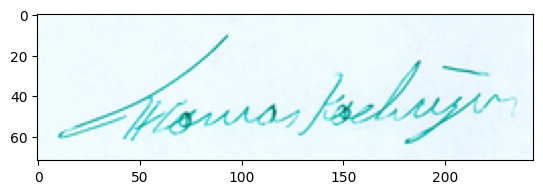

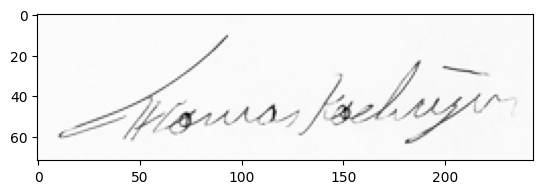

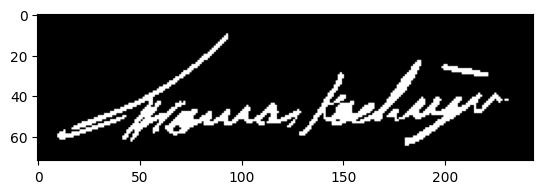

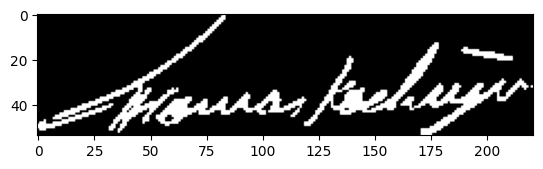

Forged Image


In [16]:
n_input=9
gui()